<a href="https://colab.research.google.com/github/Alejandro-ZZ/Machine-Learning/blob/master/TP-3/Fog_event_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **✈️ Fog event forecasting**

* **Description**: construction and comparison of sets of decision trees to predict the appearance of **fog** in the next hour. The fog event is defined as a decrease in visibility of less than 2 km.

* **Model**: Random Forests, AdaBoost and Gradinet Boosting algorithms are implemented based on multiple trees.

* **Data**: meteorological data from the Ezeiza weather station with hourly measurements since 1979.
<br>

### **👨‍💻 Authors:**


Steven Martinez Vargas

[![](https://img.shields.io/badge/Linkedin-0A66C2?style=for-the-badge&logo=linkedin&logoColor=white)](https://co.linkedin.com/in/steven-martinez-vargas-0a48845a)
[![](https://img.shields.io/badge/github-181717?style=for-the-badge&logo=github&logoColor=white)](https://github.com/smarvar)

Alejandro Zambrano Zabaleta

[![](https://img.shields.io/badge/Linkedin-0A66C2?style=for-the-badge&logo=linkedin&logoColor=white)](https://co.linkedin.com/in/alejandrozambranozabaleta)
[![](https://img.shields.io/badge/github-181717?style=for-the-badge&logo=github&logoColor=white)](https://github.com/Alejandro-ZZ)

# **1. Base configuration**

In [1]:
#@title 1.1. Packages

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os, time
from tqdm.auto import tqdm
from pathlib import Path
from graphviz import Source
from datetime import datetime as dt

import sklearn
from sklearn.calibration import calibration_curve
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc


print("=============  Package versions  =============")
print()
print("Scikit-learn:", sklearn.__version__)
print("Numpy:", np.__version__)
print("Pandas:", pd.__version__)

=============  Package versions  =============

Scikit-learn: 1.2.2
Numpy: 1.22.4
Pandas: 1.5.3


In [2]:
#@title 1.2. Constants

# Set your current working directory if the notebook and the data
# files are located in different paths
#os.chdir('.../<data_directory>')

# Base path to read data and save output images
BASE_ROOT = os.getcwd()

# Root of the meteorological data
DATA_FILE_PATH = os.path.join(BASE_ROOT, "meteorological_data_Ezeiza.txt")

# Visibility threshold to define a fog event
VIS_THRESHOLD = 2.0 # km

# Features from meteorological to build the model
FEATURES = ['windspeed', 'vis', 'rh']

# Value used for missing data
MISSING_VALUE = -9999.99

# Directory to save output images
IMAGES_PATH = os.path.join(BASE_ROOT, "out_imgs")

## 1.3. Utility functions

In [3]:
#@title *Data reading*

def read_raw_data(file_path, undef=-9999.99):
    """
    Read raw weather data from a text file and store it in a dictionary.

    Parameters:
        file_path: string
                   The path to the input text file containing weather data.

        undef: float, optional
               The undefined value used for missing data. Default is -9999.99.

    Returns:
        dict: A dictionary containing the weather data with the following keys:
            - 'dates': A list of datetime objects representing the dates.
            - 'temperature': An array of temperature values.
            - 'dewpoint': An array of dew point values.
            - 'windspeed': An array of wind speed values.
            - 'winddir': An array of wind direction values.
            - 'vis': An array of visibility values.
            - 'rh': An array of relative humidity.
            - 'pressure': An array of pressure values.
            - 'undef': The undefined value used for missing data.
    """
    # Output dictionary
    data = {}

    # Read data and remove header
    with open(file_path) as f:
        lines = f.readlines()
    lines = lines[27:]

    # NumPy arrays for each variable
    total_dates = len(lines)
    dates = []
    pressure = np.zeros(total_dates)
    temperature = np.zeros(total_dates)
    dewpoint = np.zeros(total_dates)
    windspeed = np.zeros(total_dates)
    winddir = np.zeros(total_dates)
    vis = np.zeros(total_dates)

    for index, line in enumerate(lines):
        # Extract data from specific columns and handle missing values
        pressure_val = float(line[59:66].strip()) if line[59:66].strip() else undef
        temperature_val = float(line[22:27].strip()) if line[22:27].strip() else undef
        dewpoint_val = float(line[46:50].strip()) if line[46:50].strip() else undef
        winddir_val = float(line[37:40].strip()) if line[37:40].strip() else undef
        windspeed_val = float(line[41:44].strip()) if line[41:44].strip() else undef
        vis_val = float(line[29:32].strip()) if line[29:32].strip() else undef

        # Store data in respective arrays
        pressure[index] = pressure_val
        temperature[index] = temperature_val
        dewpoint[index] = dewpoint_val
        winddir[index] = winddir_val
        windspeed[index] = windspeed_val
        vis[index] = vis_val

        # Process the date
        if line[19] == ' ':
            mystrdate = line[8:16] + '0' + line[20:21]
        else:
            mystrdate = line[8:16] + line[19:21]

        # Convert the date to a date object.
        dates.append(dt.strptime(mystrdate, '%d%m%Y%H'))

    # Compute the relative humidity and the visibility in km
    rh = _rh_from_dewpoint(temperature, dewpoint , undef)
    kmvis = _synopvis_to_kmvis(vis, undef)

    # Store data in the dictionary and return it
    data['dates'] = dates
    data['temperature'] = temperature
    data['dewpoint'] = dewpoint
    data['windspeed'] = windspeed
    data['winddir'] = winddir
    data['vis'] = kmvis
    data['rh'] = rh
    data['pressure'] = pressure
    data['undef'] = undef

    return data


def _rh_from_dewpoint(T, Td, undef):
    """
    Calculate relative humidity (RH) from given air temperature (T)
    and dew point temperature (Td) using Bolton's formula.

    Parameters:
        T: numpy.ndarray
           Air temperature in degrees Celsius.

        Td: numpy.ndarray
            Dew point temperature in degrees Celsius.

        undef: float, optional
               The value used to represent undefined or missing data.
               Defaults to -9999.99.

    Returns:
        numpy.ndarray: An array of relative humidity values calculated
                       for each corresponding pair of air temperature
                       and dew point temperature. The output RH array
                       contains 'undef' for elements where either T or Td
                       is missing or where Td is greater than T.

    Notes:
        - This function requires NumPy arrays for T and Td to process
          multiple temperature values simultaneously.

        - It is important to ensure that both T and Td arrays are of
          the same length.
    """
    if T.shape != Td.shape:
        raise ValueError("Both `T` and `Td` arrays must be the same length.")

    es_t = 6.112 * np.exp( 17.67 * T / ( T + 243.5 ) )
    es_td = 6.112 * np.exp( 17.67 * Td / ( Td + 243.5 ) )
    rh = es_td / es_t
    rh[np.logical_or(T == undef , Td == undef)] = undef
    rh[Td > T] = undef

    return rh


def _synopvis_to_kmvis(synop_vis, undef):
    """
    Convert SYNOP visibility codes to visibility values in kilometers.

    Parameters:
        synop_vis: numpy.array
                   Array of SYNOP visibility codes.

        undef: float
               The value used to represent undefined or missing data.

    Returns:
        numpy.array: Array containing visibility values in kilometers.
    """

    # Conversion table for SYNOP codes to visibility in kilometers.
    conversion_table = {
        90: 0.0, 91: 0.05, 92: 0.2, 93: 0.5, 94: 1.0, 95: 2.0,
        96: 4.0, 97: 10.0, 98: 20.0, 99: 50.0,
    }

    # Initialize km_vis with undef value (avoiding any uninitialized values).
    km_vis = np.full_like(synop_vis, undef, dtype=float)

    # Replace SYNOP codes with corresponding visibility values in km.
    km_vis = np.where((synop_vis > 0) & (synop_vis < 50), synop_vis * 0.1, km_vis)
    km_vis = np.where((synop_vis >= 56) & (synop_vis <= 80), synop_vis - 50.0, km_vis)

    # Check for specific conversions in the table.
    for code, km_value in conversion_table.items():
        km_vis = np.where(synop_vis == code, km_value, km_vis)

    # Handle specific conversions for SYNOP codes 81 to 89
    # Technically, code 89 should be greater than 70.0.
    km_vis = np.where((synop_vis >= 81) & (synop_vis <= 89), 5*synop_vis - 370.0, km_vis)

    # Handle undefined or missing data.
    km_vis[synop_vis == undef] = undef

    return km_vis


In [4]:
#@title *Model evaluation*

def eval_grid(params, predictions, plot_title, model_name, save):
    """
    Generate and display a grid plot with ROC curves and calibration curves
    for multiple models.

    Parameters:
        params: list
                Model hyperarameter values.

        predictions: list
                     A list of tuples, each containing two arrays:

                        1. The predicted labels or classes.
                        2. The predicted probabilities for the
                            positive class.

        plot_title: string
                    The title for the grid plot.

        model_name: string
                    The name of the model, used for generating the
                    output plot filename.

        save: boolean
              A boolean value indicating whether to save the plot as an image.

    Returns:
        None

    Notes:
        - The ROC curve shows the True Positive Rate against the
          False Positive Rate for each model.

        - The Calibration curve shows the true probability against
          the predicted probability for each model.

        - The diagonal reference line is added to both plots to show
          the random chance performance.

        - The plots will be displayed, and optionally, saved as an image
          with the given model_name.

    Example:
        params = [hyperparameter_A, hyperparameter_B, hyperparameter_C]
        predictions = [(y_pred_A, y_prob_A), (y_pred_B, y_prob_B), (y_pred_C, y_prob_C)]
        plot_title = 'Model Comparison'
        model_name = 'ensemble_model'
        save = True

        eval_grid(params_list, predictions_list, plot_title, model_name, save)
    """
    # Grid plot
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle(plot_title, fontsize=16, fontweight='bold')

    for i in range(len(predictions)):
        y_pred, y_prob = predictions[i]

        # ROC curve plot
        _roc_curve(y_test, y_prob, ax=axs[0], label=str(params[i]))

        # Calibration curve plot
        _calibration_curve(y_train, y_test, y_prob, ax=axs[1], label=str(params[i]))

    # Add diagonal reference line and set axis labels and titles
    axs[0].plot([0, 1], [0, 1], linestyle='--', color='gray')
    axs[0].set_xlabel('False Positive Rate')
    axs[0].set_ylabel('True Positive Rate')
    axs[0].set_title('ROC curves')
    axs[0].grid(True)
    axs[0].legend()

    axs[1].plot([0, 1], [0, 1], linestyle='--', color='gray')
    axs[1].set_xlabel('Predicted probability')
    axs[1].set_ylabel('True probability')
    axs[1].set_title('Calibration curves')
    axs[1].grid(True)
    axs[1].legend()

    # Adjust spacing between subplots and display plot
    plt.tight_layout()
    if save:
        filename=f'{model_name}_metrics.png'
        plt.savefig(os.path.join(IMAGES_PATH, filename), dpi=300)
    plt.show()



def evaluate(model, save, model_name, plot_title, cm_normalize=None):
    """
    Evaluate a machine learning model by generating and displaying a grid plot
    with the confusion matrix, ROC curve and calibration curve.

    Parameters:
        model: sklearn estimator instance
               The trained machine learning model to be evaluated.

        save: boolean, optional
              A boolean value indicating whether to save the plot as
              an image. Default is False.

        model_name: string, optional
                    The name of the model, used for generating the output
                    plot filename. Default is None.

        plot_title: string, optional
                    The title for the grid plot. Default is None.

        cm_normalize: string, optional
                      The normalization method for the confusion matrix.
                      Valid values: {'true', 'pred', 'all', None}.
                      Default is None.

    Notes:
        - The function will evaluate the given model by generating a grid
          plot with three subplots.

        - The first subplot displays the confusion matrix.

        - The second subplot shows the Receiver Operating Characteristic
          (ROC) curve.

        - The third subplot presents the Calibration curve.

        - The predictions and probabilities for the positive class will be
          computed over the test set.

        - If `save` is set to True, the plot will be saved as an image with
          the given `model_name`.

        - If `save` is False, the plot will be displayed directly without
          saving.

    Example:
        model = RandomForestClassifier()
        save = True
        model_name = 'random_forest'
        plot_title = 'Model Evaluation'
        cm_normalize = 'true'

        evaluate(model, save=save, model_name=model_name, plot_title=plot_title, cm_normalize=cm_normalize)
    """

    # Generate predictions and compute the probabilities (of
    # the positive class) over the test set
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    # Grid plot
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(plot_title, fontsize=16, fontweight='bold')

    # Confusion matrix, ROC and Calibration curve plot
    _cofusion_matrix(y_test, y_pred, ax=axs[0], normalize=cm_normalize)
    _roc_curve(y_test, y_prob, ax=axs[1])
    _calibration_curve(y_train, y_test, y_prob, ax=axs[2])

    plt.tight_layout()
    if save:
        filename=f'{model_name}_metrics.png'
        plt.savefig(os.path.join(IMAGES_PATH, filename), dpi=300)
    plt.show()



def _cofusion_matrix(test, pred, ax, normalize=None):
    """
    Helper function of `evaluate()` to create a confusion matrix.
    """
    # Get F1-score
    f1 = f1_score(test, pred)

    # Get confusion matrix
    cm = confusion_matrix(test, pred, normalize=normalize)
    df_cm = pd.DataFrame(cm, index=['No fog', 'Fog'], columns=['No fog', 'Fog'])

    # Create visualization of confusion matrix
    format = '.3f' if normalize else 'g'
    sns.heatmap(df_cm, annot=True, cmap='Blues', fmt=format, cbar=False, ax=ax)
    ax.set_title(f'F1-score = {f1:.3f}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True value')


def _roc_curve(test, prob, ax, label=None):
    """
    Helper function of `evaluate()` to create a ROC curve.
    """
    fpr, tpr, thresholds = roc_curve(test, prob)
    roc_auc = auc(fpr, tpr)

    if label:
        ax.plot(fpr, tpr, lw=2, label=f'{label} (AUC={roc_auc:.3f})')
    else:
        ax.plot(fpr, tpr, color='darkorange', lw=2)
        ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        ax.set_xlabel('False positive rate')
        ax.set_ylabel('True positive rate')
        ax.set_title('AUC = %0.2f' % roc_auc)
        ax.grid(True)


def _calibration_curve(train, test, prob, ax, label=None):
    """
    Helper function of `evaluate()` to create a calibration curve.
    """
    true_prob, pred_prob = calibration_curve(test, prob, n_bins=10)

    # Computes the Brier Skill Score (BSS)
    bss = _brier_skill_score(train, test, prob)

    if label:
        ax.plot(pred_prob, true_prob, marker='o', label=f'{label} (BSS={bss:.3f})')
    else:
        ax.plot(pred_prob, true_prob, marker='o')
        ax.plot([0, 1], [0, 1], linestyle='--', color='black')
        ax.set_xlabel('Predicted Probability of Positive Class')
        ax.set_ylabel('True Probability of Positive Class')
        ax.set_title('BSS = %0.2f' % bss)
        ax.grid(True)


def _brier_score(test, prob):
    """
    Helper function to compute the Brier score. See more details in:

        https://en.wikipedia.org/wiki/Brier_score#Definition
    """
    return np.mean((prob - test)**2)


def _brier_skill_score(train, test, prob):
    """
    Helper function to compute the Brier skill score. See more details in:

        https://en.wikipedia.org/wiki/Brier_score#Brier_Skill_Score_(BSS)
    """
    # "climatological" probability of occurrence of the fog event
    fog_event_prob = np.mean(train)
    fog_event_brier = _brier_score(fog_event_prob , test)
    model_brier = _brier_score(test, prob)
    return 1.0 - model_brier/fog_event_brier

In [5]:
#@title *Others*

def save_decision_tree(tree_model, filename):
    """
    Save a decision tree model as an image file.

    Parameters:
        tree_model: sklearn estimator instance
                    The trained decision tree model to be saved.

        filename: string
                  The name of the image file to be generated
                  (without the file extension).

    Notes:
        - The function exports the decision tree to .dot format.

        - It generates a visualization of the tree using the Graphviz library.

        - The visualization includes feature names and class names for
          better interpretation.

        - The visualization will be saved in the `IMAGES_PATH` directory
          with the given filename.

        - The image file format will be 'jpg'.

    Example:
        from sklearn.tree import DecisionTreeClassifier

        # Assuming tree_model is a trained DecisionTreeClassifier
        tree_model = DecisionTreeClassifier()
        filename = 'decision_tree_visualization'

        save_decision_tree(tree_model, filename)
    """

    # Exports decision tree to .dot format
    dot_data = tree.export_graphviz(tree_model, out_file=None,
                                    feature_names=FEATURES,
                                    class_names=['No fog', 'Fog'],
                                    filled=True, rounded=True,
                                    special_characters=True)

    # Generates a visualization of the tree
    graph = Source(dot_data)

    # Saves the visualization in image file
    graph.render(os.path.join(IMAGES_PATH, filename), format='jpg')

# **2. Dataset creation**

The data from the Ezeiza weather station have the following variables:


|   Name      | Description |
| :-          | :-|
|`dates`      | date and time (yyyy-mm-dd hh:mm)|
|`temperature`| temperature in degrees Celsius|
|`dewpoint`   | dew point temperature in degrees Celsius|
|`windspeed`  | wind speed in km/h|
|`winddir`    | wind direction in degrees (99.0 identifies calm)|
|`vis`        | visibility in km|
|`rh`         | relative humidity between 0 and 1|
|`pressure`   | pressure in hPa|
|`undef`      | missing values|


The target variable (`fog`) is defined as visibility (`vis`) less than 2 km ($\text{vis}<2$), therefore when `fog = 1` it will correspond to a fog event.

## 2.1. Load data

In [6]:
# Read raw data
data = read_raw_data(DATA_FILE_PATH)
data_df = pd.DataFrame(data)

# Expected number of observations
assert (len(data_df) == 281147), 'Number of observations read incomplete'

# Create target variable
# data_df['fog'] = (data['vis'] < VIS_THRESHOLD).astype(int)
data_df['fog'] = (np.logical_and(data_df.vis < VIS_THRESHOLD,
                                 data_df.vis != MISSING_VALUE)).astype(float)

# Add `MISSING_VALUE` code to rows where visibility is 0.0 or undefined values
data_df.loc[data_df.vis == data_df.undef, 'fog'] = MISSING_VALUE
data_df.loc[data_df.vis == 0.0, 'fog'] = MISSING_VALUE
data_df

,dates,temperature,dewpoint,windspeed,winddir,vis,rh,pressure,undef,fog
0,1979-01-01 00:00:00,20.2,10.4,6.0,11.0,15.0,0.532709,1013.4,-9999.99,0.0
1,1979-01-01 01:00:00,19.2,10.4,6.0,11.0,15.0,0.566845,1014.1,-9999.99,0.0
2,1979-01-01 02:00:00,17.0,11.4,2.0,11.0,15.0,0.695680,1015.0,-9999.99,0.0
3,1979-01-01 03:00:00,15.2,11.5,2.0,11.0,15.0,0.785587,1015.3,-9999.99,0.0
4,1979-01-01 04:00:00,14.2,11.3,2.0,11.0,15.0,0.826935,1015.7,-9999.99,0.0
...,...,...,...,...,...,...,...,...,...,...
281142,2011-01-31 19:00:00,28.9,19.9,10.0,23.0,10.0,0.582921,1005.3,-9999.99,0.0
281143,2011-01-31 20:00:00,28.7,20.8,10.0,23.0,9.0,0.623458,1005.7,-9999.99,0.0
281144,2011-01-31 21:00:00,29.1,19.7,10.0,23.0,9.0,0.569097,1005.9,-9999.99,0.0
281145,2011-01-31 22:00:00,28.1,20.3,8.0,23.0,9.0,0.625997,1006.5,-9999.99,0.0


## 2.2. Fog event

The objective is that, based on the relative humidity (`rh`), visibility (`vis`) and wind speed (`windseep`) at a given time, the algorithm is capable of indicating the probability that visibility is less than 2 km. in the next hour (fog event).

Given the previous information, the data in the `fog` column must be modified to match the observations in the previous hour. Example: suppose the following data for 5 different hours is known:

| windspeed | vis |  rh  | fog |
|:---------:|:---:|:----:|:---:|
|     10    |  3  | 0.70 |  0  |
|     15    |  2  | 0.75 |  1  |
|     12    | 1.5 | 0.80 |  1  |
|     8     | 2.5 | 0.85 |  0  |
|     5     |  4  | 0.90 |  0  |


To predict the target (`fog`) of the next hour, the data is rearranged as follows:

| windspeed | vis |  rh  | fog |
|:---------:|:---:|:----:|:---:|
| 10        | 3   | 0.70 | 1   |
| 15        | 2   | 0.75 | 1   |
| 12        | 1.5 | 0.80 | 0   |
| 8         | 2.5 | 0.85 | 0   |
| 5         | 4   | 0.90 | NaN |


Note that the last row has a null value (`NaN`) in the target (`fog`), since the information about the next hour's fog event for that last record is not known.

In [7]:
# Reorder the data to predict the target in the next hour
# and drop the last observation.
data_df['fog_shifted'] = data_df['fog'].shift(-1)
data_df.dropna(inplace=True)
print('[INFO] Number of observations (rows, columns):', data_df.shape)


fog_ratio = np.mean(data_df.loc[data_df.fog_shifted != MISSING_VALUE, 'fog_shifted'])
print('\n[INFO] Total number of fog events:', np.sum(data_df.fog_shifted == 1.0))
print('[INFO] Percentage of cases of fog (`vis < {0}`): {1:.1f}%'.format(VIS_THRESHOLD,
                                                                         fog_ratio*100))

[INFO] Number of observations (rows, columns): (281146, 11)

[INFO] Total number of fog events: 10071
[INFO] Percentage of cases of fog (`vis < 2.0`): 3.7%


When calculating the percentage of positive cases (`fog = 1`) with respect to the total data, it is observed that the categories are very unbalanced. This might generate a bias in the model towards the negative cases (`fog = 0`), underestimating the cases of fog. This is essential when implementing the algorithms and a metric to know their performance.

## 2.3. Features and target

Although tests can be done to define the best combination of features, initially the following are used:

1. Wind speed (`windspeed`): little or no wind should help limit visibility.

2. Relative humidity (`rh`): values close to 100% (1) humidity should be associated with fog and therefore a decrease in visibility.

3. Visualization (`vis`): when predicting the dynamics of visibility in the next hour, low values of it in the previous time describe a lower possibility of a fog event in the next hour.

In [8]:
# Create features (X) and target (y)
X = data_df.loc[:, FEATURES].to_numpy()
y = data_df.loc[:, 'fog_shifted'].to_numpy()
print('[INFO] Features shape:', X.shape)
print('[INFO] Target shape:', y.shape)

[INFO] Features shape: (281146, 3)
[INFO] Target shape: (281146,)


* Within the data acquisition, there are times when it is not possible to have a reading of some of the predictor variable (`X`). These data can cause confusion in the model since they do not represent representative information for the desired objective.

* Values with missing data are represented by a constant defined in `MISSING_VALUE` (in this case it is `-9999.99`). From this, a cleaning is carried out to eliminate observations that present these cases in any of the predictor variables.

In [9]:
# Remove missing data
# Missing data has a default value of: -9999.99
print('[INFO] Missing value code is:', MISSING_VALUE)
missing_data_mask = np.any(X == MISSING_VALUE , axis=1)
missing_data_mask[y == MISSING_VALUE] = True
print('[INFO] Total missing values:', np.sum(missing_data_mask))

X_cleaned = X[~missing_data_mask]
y_cleaned = y[~missing_data_mask]
print('\n[INFO] Cleaned features shape:', X_cleaned.shape)
print('[INFO] Cleaned target shape:', y_cleaned.shape)

# Train - Test split
X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y_cleaned, test_size=0.2, shuffle=False)
print('\n[INFO] Train features shape:', X_train.shape)
print('[INFO] Train target shape:', y_train.shape)

print('\n[INFO] Test features shape:', X_test.shape)
print('[INFO] Test target shape:', X_test.shape)

[INFO] Missing value code is: -9999.99
[INFO] Total missing values: 16319

[INFO] Cleaned features shape: (264827, 3)
[INFO] Cleaned target shape: (264827,)

[INFO] Train features shape: (211861, 3)
[INFO] Train target shape: (211861,)

[INFO] Test features shape: (52966, 3)
[INFO] Test target shape: (52966, 3)


# **3. Data analysis**

Before training some machine learning algorithm, lets analyze the data.

* Correlation matrix

In [18]:
# Lets create a dataframe with the just dates, features and target coulmns
df = data_df.loc[:, ['dates', 'windspeed', 'vis', 'rh', 'fog_shifted']]
df_cleaned = df.iloc[~missing_data_mask]
df_cleaned.set_index('dates', inplace=True)

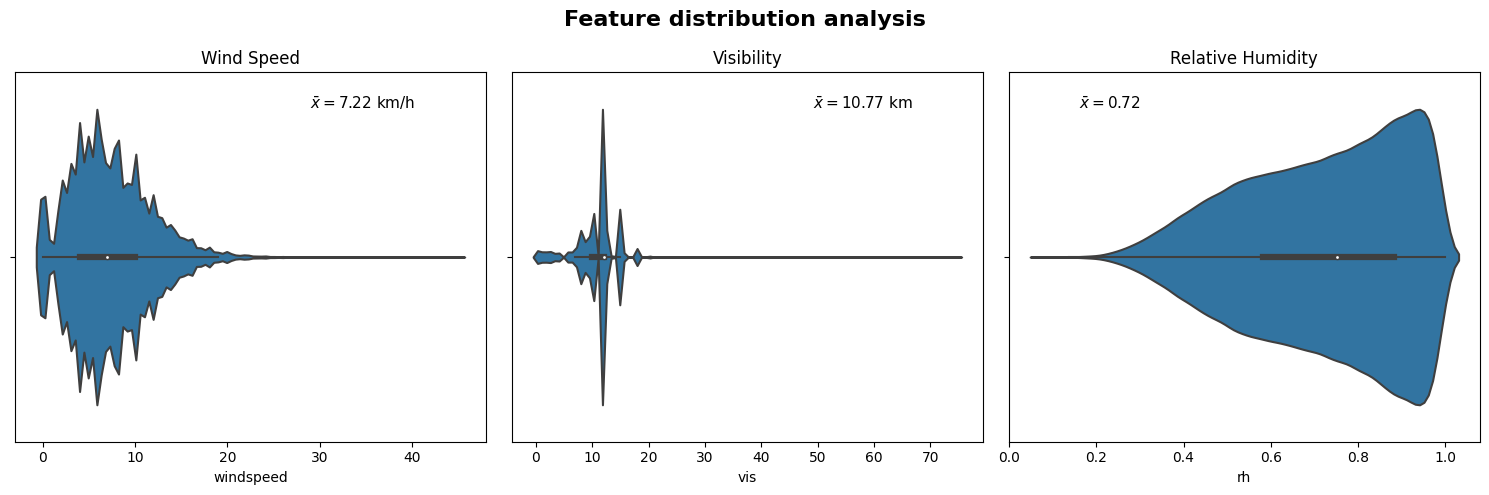

In [19]:
#@title 3.1. Distribution

# Create the grid plot with 1 row and 3 columns
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Violin plots for each feature
sns.violinplot(x=df_cleaned['windspeed'], ax=axes[0])
sns.violinplot(x=df_cleaned['vis'], ax=axes[1])
sns.violinplot(x=df_cleaned['rh'], ax=axes[2])

# Calculate mean values for each column
mean_windspeed = df_cleaned['windspeed'].mean()
mean_visibility = df_cleaned['vis'].mean()
mean_rh = df_cleaned['rh'].mean()

# Set titles for each subplot, including the mean value
axes[0].set_title(f'Wind Speed')
axes[1].set_title(f'Visibility')
axes[2].set_title(f'Relative Humidity')

# Add mean value labels to each violin plot
axes[0].text(0.85, 0.9, f'$\\bar{{x}}={mean_windspeed:.2f}$ km/h', transform=axes[0].transAxes, fontsize=11, ha='right')
axes[1].text(0.85, 0.9, f'$\\bar{{x}}={mean_visibility:.2f}$ km', transform=axes[1].transAxes, fontsize=11, ha='right')
axes[2].text(0.15, 0.9, f'$\\bar{{x}}={mean_rh:.2f}$', transform=axes[2].transAxes, fontsize=11, ha='left')


# Set the general title for the grid plot
plt.suptitle('Feature distribution analysis', fontsize=16, fontweight='bold')

# Display the plot
plt.tight_layout()
plt.show()

**Wind spped (`windspeed`)**

* A right long line indicates that there are unusually high wind speed values that fall beyond the upper whisker. These high wind speed values could be rare but significant events, such as strong gusts during storms or other extreme weather conditions.

* Wind speeds are generally more frequently observed at lower values (less than 15 km/h), while higher wind speeds occur less frequently but are more extreme when they do occur (up to 45 km/h).

**Visibility (`vis`)**

* Distribution suggests the presence of outliers (unusually high compared to the majority of data points) or high visibility values corresponding to periods of exceptionally clear weather, such as sunny and cloudless days.

* There is a dense peak around the mean value indicating that the majority of visibility measurements fall within a specific range. This range represents the typical visibility conditions which are more frequent than extreme events.

**Relative Humidity (`rh`)**

* The majority of values are concentrated towards the higher end (0.8 and 0.9). This suggests that the region or time period covered by the dataset experiences more frequent occurrences of higher relative humidity values.

* The presence of a left whisker from 0 to 0.2 indicates the occurrence of extremely low relative humidity values. This could represent specific weather events or unique conditions during which relative humidity drops significantly below the typical range.

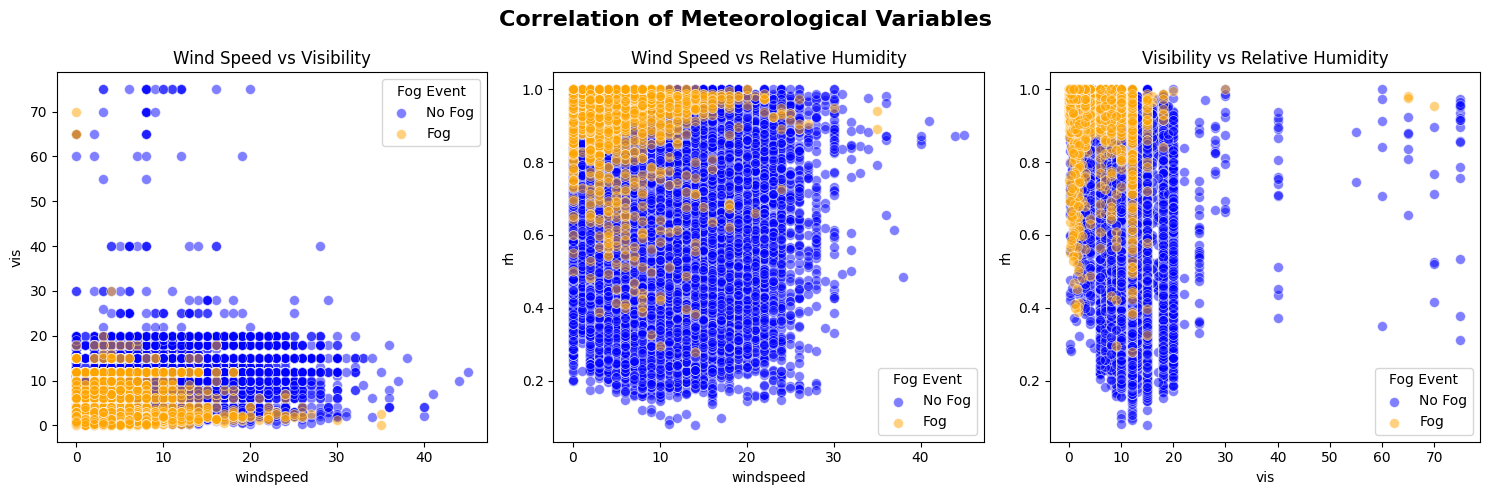

In [43]:
#@title 3.2. Correlation

plt.figure(figsize=(15, 5))

# Wind speed vs visibility
plt.subplot(1, 3, 1)
sns.scatterplot(data=df_cleaned[df_cleaned['fog_shifted'] == 0], x='windspeed', y='vis', color='blue', alpha=0.5, s=50, zorder=2)
sns.scatterplot(data=df_cleaned[df_cleaned['fog_shifted'] == 1], x='windspeed', y='vis', color='orange', alpha=0.5, s=50, zorder=3)
plt.title('Wind Speed vs Visibility')
plt.legend(title='Fog Event', labels=['No Fog', 'Fog'])

# Wind speed vs relative humidity
plt.subplot(1, 3, 2)
sns.scatterplot(data=df_cleaned[df_cleaned['fog_shifted'] == 0], x='windspeed', y='rh', color='blue', alpha=0.5, s=50, zorder=2)
sns.scatterplot(data=df_cleaned[df_cleaned['fog_shifted'] == 1], x='windspeed', y='rh', color='orange', alpha=0.5, s=50, zorder=3)
plt.title('Wind Speed vs Relative Humidity')
plt.legend(title='Fog Event', labels=['No Fog', 'Fog'])

# Visibility vs relative humidity
plt.subplot(1, 3, 3)
sns.scatterplot(data=df_cleaned[df_cleaned['fog_shifted'] == 0], x='vis', y='rh', color='blue', alpha=0.5, s=50, zorder=2)
sns.scatterplot(data=df_cleaned[df_cleaned['fog_shifted'] == 1], x='vis', y='rh', color='orange', alpha=0.5, s=50, zorder=3)
plt.title('Visibility vs Relative Humidity')
plt.legend(title='Fog Event', labels=['No Fog', 'Fog'])

plt.suptitle('Correlation of Meteorological Variables', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

Most of the fog events corresponds to the following previous hour meteorological values:

* $\text{wind speed} \leq 15 \text{km/h}$
* $\text{visibility} \leq 12 \text{km}$
* $\text{relative huimidity} \geq 80%$

However, there are two points where a fog event occurs and the visibility in the previous hour was 65 km and 70 km, which are the two most unusual cases shown.


       fog_shifted
count    33.000000
mean    288.333333
std      89.314286
min       0.000000
25%     231.000000
50%     304.000000
75%     344.000000
max     455.000000 



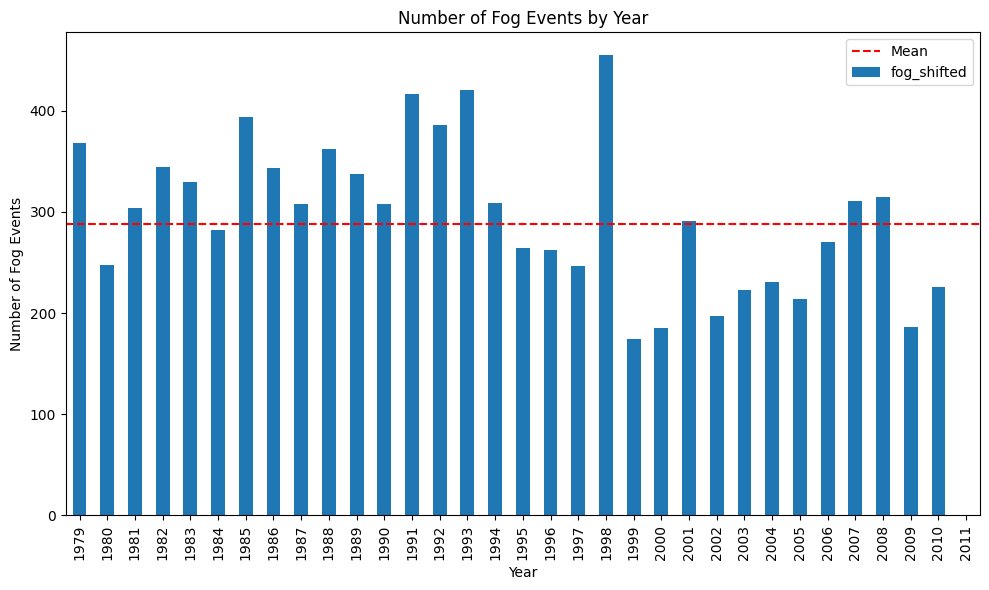

In [41]:
#@title 3.3. Fog events

# Create a new DataFrame to hold the frequency distribution by year
fog_event_distribution = df_cleaned.loc[:, ['fog_shifted']]
fog_event_distribution['fog_shifted'] = fog_event_distribution['fog_shifted'].astype(bool)

# Group data by year and count the fog events for each year
fog_events_by_year = fog_event_distribution.resample('Y').sum()
print(fog_events_by_year.describe(), '\n')

# Plot the bar chart
fig, ax = plt.subplots(figsize=(10, 6))
fog_events_by_year.plot(kind='bar', ax=ax)
ax.set_xlabel('Year')
ax.set_ylabel('Number of Fog Events')
ax.set_title('Number of Fog Events by Year')

# Plot mean line
ax.axhline(y=int(fog_events_by_year.mean()), color='red', linestyle='--', label='Mean')
ax.legend()

# Format X-axis labels to display only the year
ax.set_xticklabels(fog_events_by_year.index.year)

plt.tight_layout()
plt.show()

Most of the years present more than 300 fog events, being 1998 the year with the highest number of events (455) and 1999 the one with the fewest (around 150).

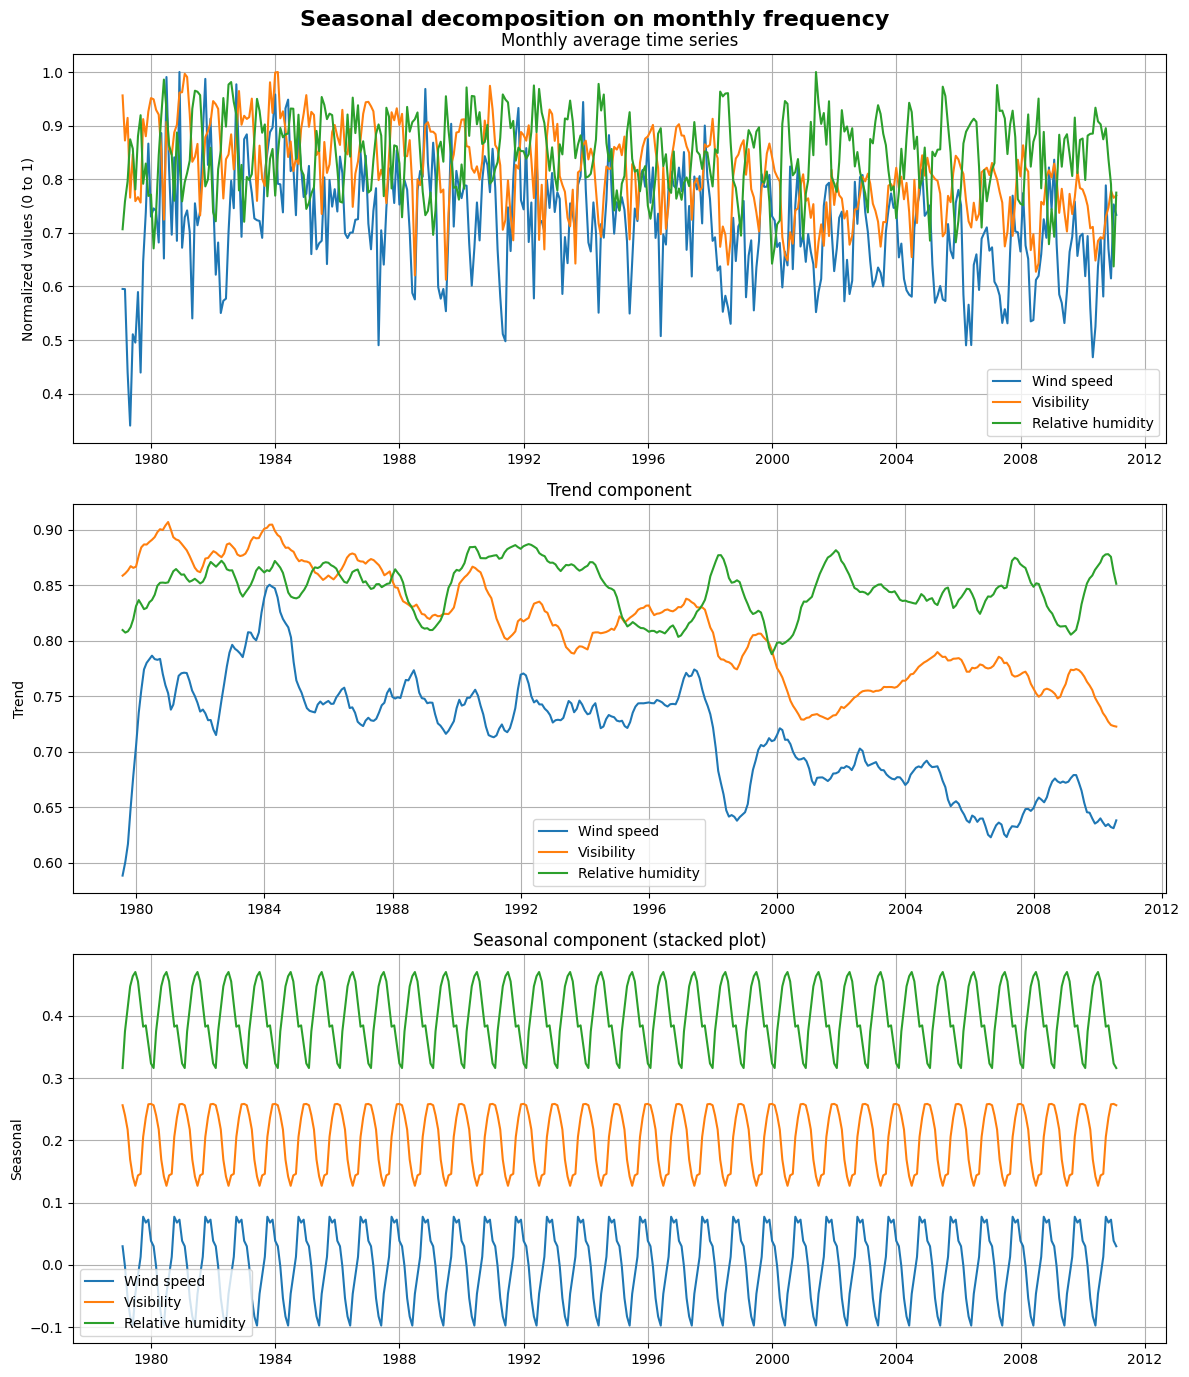

In [51]:
#@title 3.4. Seasonal decomposition

import statsmodels.api as sm

# Resample the data to monthly frequency
#df_preiodic = df_cleaned.loc[(df_cleaned.index.year >= 1992) & (df_cleaned.index.year <= 2000)]
#df_preiodic = df_cleaned.loc[df_cleaned.index.year >= 1995]
df_periodic = df_cleaned.copy()
df_periodic = df_periodic.resample('M').mean()

# Scale values to range [0, 1]
df_normalized = df_periodic / df_periodic.max()

# List of features to plot
features = {"Wind speed": 'windspeed',
            "Visibility": 'vis',
            "Relative humidity": 'rh'}

# Create a grid plot to display the original, trend, seasonal, and residual components
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 14))
for i, (name, column) in enumerate(features.items()):
    # Seasonal decomposition
    decomposition = sm.tsa.seasonal_decompose(df_normalized[column], model='additive')

    # Line plots
    axes[0].plot(df_normalized[column], label=name)          # original
    axes[1].plot(decomposition.trend, label=name)            # trend
    axes[2].plot(decomposition.seasonal + 0.2*i, label=name) # seasonal (stacked)
    #axes[3].plot(decomposition.resid, label=name)            # residual

# Labels, grid, titles and legends
axes[0].set_ylabel('Normalized values (0 to 1)')
axes[0].set_title('Monthly average time series')
axes[0].legend()
axes[0].grid(True)

axes[1].set_ylabel('Trend')
axes[1].set_title('Trend component')
axes[1].legend()
axes[1].grid(True)

axes[2].set_ylabel('Seasonal')
axes[2].set_title('Seasonal component (stacked plot)')
axes[2].legend()
axes[2].grid(True)

# axes[3].set_ylabel('Residual')
# axes[3].set_title('Residual component')
# axes[3].legend()
# axes[3].grid(True)

plt.suptitle('Seasonal decomposition on monthly frequency', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

* In the monthly average line graph, we can see that the dynamics between wind speed and visibility are similar, while relative humidity mostly presents opposite behaviors.

* The trend component shows a decrease over time for the visibility and wind speed values. The most significant movement of data was around 1998 and 1999 where the wind speed present a high trend lo decrease.

* The seasonal component shows preiodic monthly fluctuation pattern for the three features. Wind speed tends to be higher during spring and summer, while the humidity is the opposite.

# **4. Ensemble models**

After processing the meteorological data, the three different ensembles are built. The developmetn of this consist on three section for each algorithm:

1. **Basic model**: creation and evaluation of a basic model with a relatively small number of trees (`n_estimators`) and each one shallow (low `max_depth` hyperparameter).

2. **Hyperparamers tuning**: define a grid with different lists of model parameter to evaluate the performance against its hyperparameter modification.

3. **Final model**: display the final evaluation plots for the "optimized" model.

## **4.1. Random Forest**

First a base random forest classifier is built.

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.428798 to fit



[INFO] Decision tree saved!



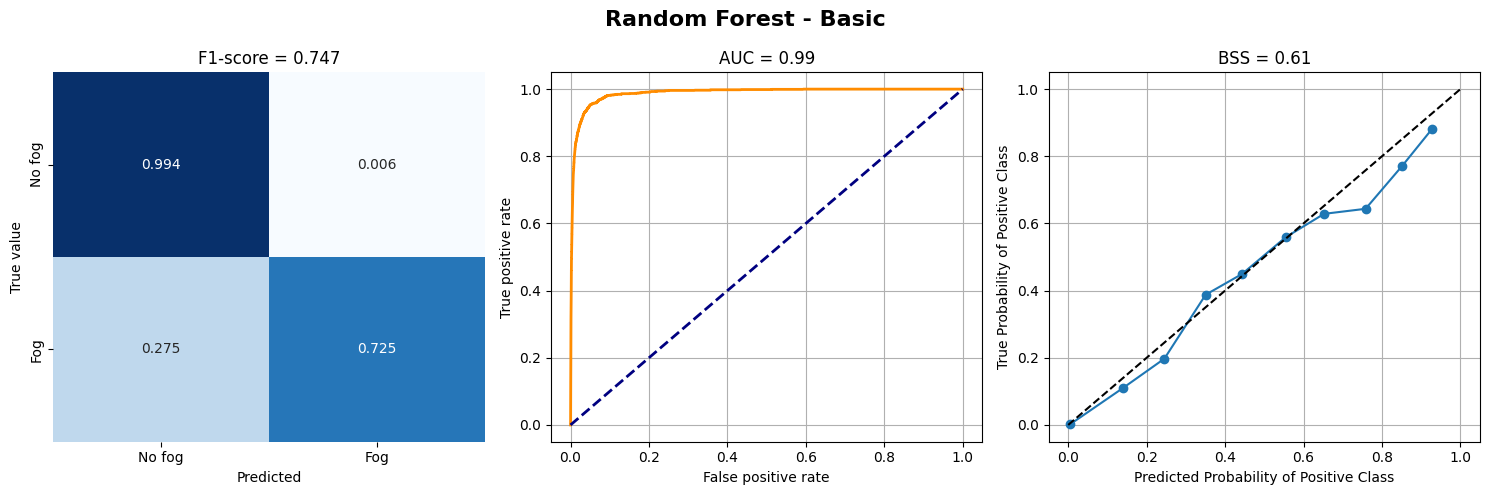

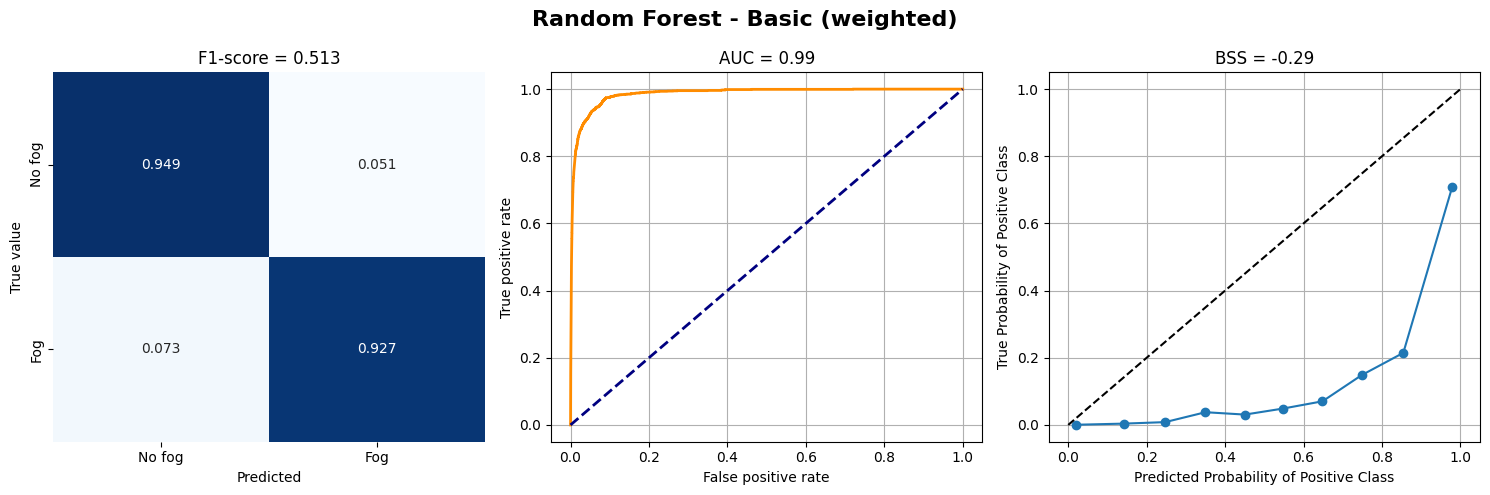

In [ ]:
#@title *Basic model*

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

# Inital parameter for the basic model
init_n_estimators = 50 #@param {type:"slider", min:10, max:500, step:10}
init_max_depth = 10 #@param {type:"slider", min:2, max:100, step:2}

# Creates and train a base classifier
# Note the used of `class_weight` since the data we
# are working on is unbalanced.
rfc_basic = RandomForestClassifier(n_estimators=50,
                                   max_depth=10,
                                   class_weight=None,
                                   random_state=23).fit(X_train, y_train)

rfc_basic_weighted = RandomForestClassifier(n_estimators=50,
                                   max_depth=10,
                                   class_weight='balanced_subsample',
                                   random_state=23).fit(X_train, y_train)

# Save a tree from the forest
tree_num = 0
save_decision_tree(tree_model=rfc_basic.estimators_[tree_num],
                    filename=f'1_rfc_basic_tree{tree_num}')
print('\n[INFO] Decision tree saved!\n')

# Metrics
evaluate(model=rfc_basic,
         save=True,
         model_name='1_rfc_basic',
         cm_normalize='true',
         plot_title='Random Forest - Basic')

evaluate(model=rfc_basic_weighted,
         save=True,
         model_name='1_rfc_basic_weighted',
         cm_normalize='true',
         plot_title='Random Forest - Basic (weighted)')

* Note that although the dataset is unbalanced, the best model performance is obtained when no weighted class is applied. Based on this results, the hyperparameters tuning is done with no weighted data.

### *Hyperparamers tuning*

Note when tuning the number of estimators the `max_depth` parameter remains constant with a value of 10 (as in the base model) and the number of estimators is changed (`n_estimators`). The same approach is done when variating the tree maximun depth (`max_depth`)

In [ ]:
# Define the parameters grid to evaluate
rfc_params_grid = {
    'n_estimators': [10, 20, 40, 80, 100, 200, 300],
    'max_depth': [None, 4, 8, 16, 32, 64]
}

n_estimators:   0%|          | 0/7 [00:00<?, ?it/s]

Execution time: 02 minutes 6.50 seconds



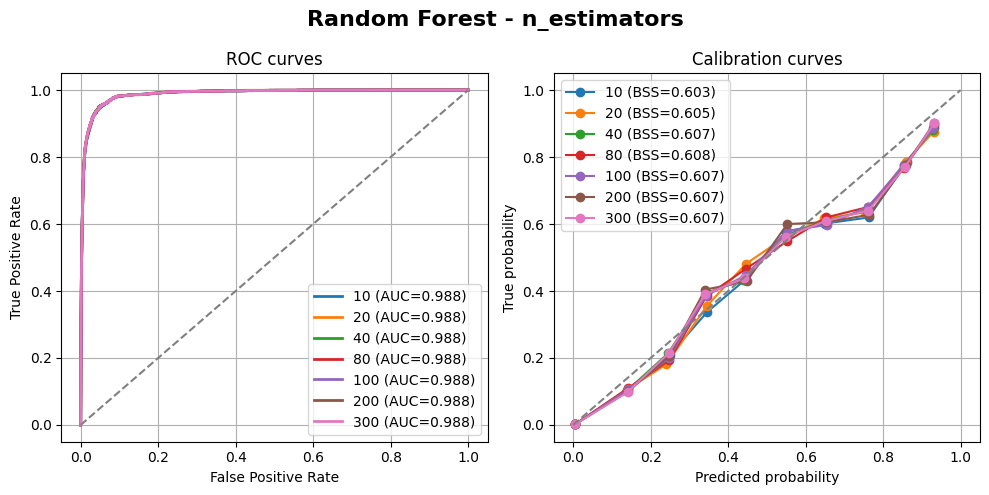

In [ ]:
#@title Number of estimators
rfc_n_estimators = []

# Use a loop to iterate over all combinations of the `n_estimators` parameter
start_time = time.time()
for n_estimators in tqdm(rfc_params_grid['n_estimators'], desc='n_estimators'):
    rf = RandomForestClassifier(n_estimators=n_estimators,
                                max_depth=10,
                                class_weight=None, #'balanced_subsample',
                                random_state=23).fit(X_train, y_train)

    # Generate predictions and compute the probabilities (of
    # the positive class) over the test set
    y_pred = rf.predict(X_test)
    y_prob = rf.predict_proba(X_test)[:, 1]

    # Save predictions
    rfc_n_estimators.append((y_pred, y_prob))
end_time = time.time()

# Format and print the elapsed time
elapsed_time = end_time - start_time
minutes, seconds = divmod(elapsed_time, 60)
print(f'Execution time: {int(minutes):02d} minutes {seconds:.2f} seconds\n')

# Plot metrics
eval_grid(params=rfc_params_grid['n_estimators'],
          predictions=rfc_n_estimators,
          plot_title='Random Forest - n_estimators',
          model_name='2_rfc_n-estimators',
          save=True)

max_depth:   0%|          | 0/6 [00:00<?, ?it/s]

Execution time: 00 minutes 59.14 seconds



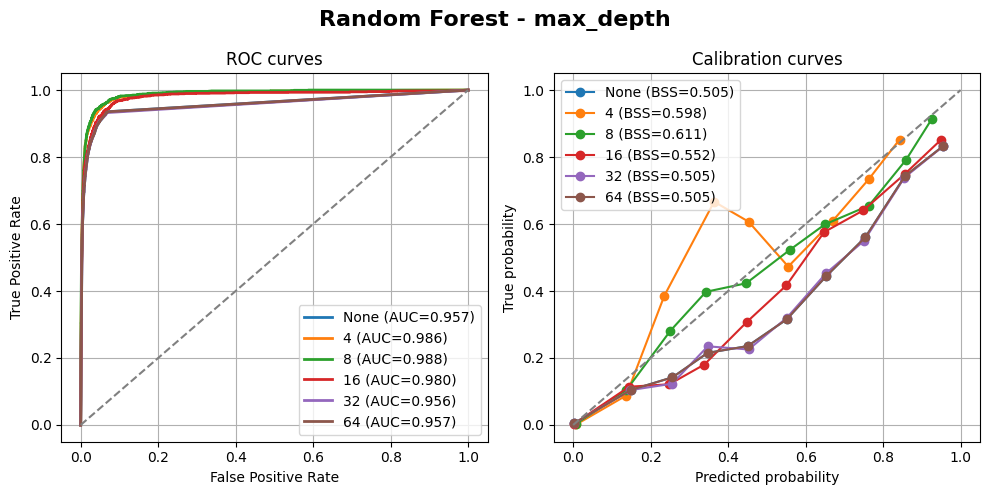

In [ ]:
#@title Maximum depth

rfc_max_depth = []

# Use a loop to iterate over all combinations of the `n_estimators` parameter
start_time = time.time()
for max_depth in tqdm(rfc_params_grid['max_depth'], desc='max_depth'):
    rf = RandomForestClassifier(n_estimators=50,
                                max_depth=max_depth,
                                class_weight=None, #'balanced_subsample',
                                random_state=23).fit(X_train, y_train)

    # Generate predictions and compute the probabilities (of
    # the positive class) over the test set
    y_pred = rf.predict(X_test)
    y_prob = rf.predict_proba(X_test)[:, 1]

    # Save predictions
    rfc_max_depth.append((y_pred, y_prob))
end_time = time.time()

# Format and print the elapsed time
elapsed_time = end_time - start_time
minutes, seconds = divmod(elapsed_time, 60)
print(f'Execution time: {int(minutes):02d} minutes {seconds:.2f} seconds\n')

# Plot metrics
eval_grid(params=rfc_params_grid['max_depth'],
          predictions=rfc_max_depth,
          plot_title='Random Forest - max_depth',
          model_name='2_rfc_max-depth',
          save=True)

### *Final model*

Finally the best performance for each hyperparameter is selected:

* *n_estimators* = 80
* *max_depth* = 8

Note how the hyperparameters in the final model differ slightly from the base model.

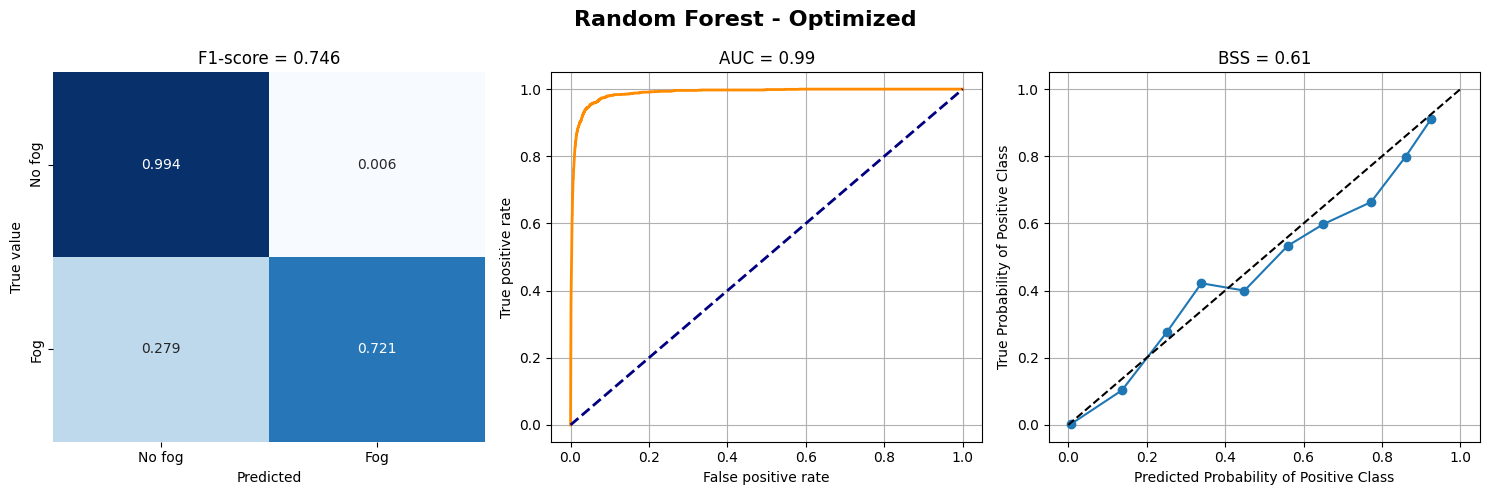

In [ ]:
rfc_opti = RandomForestClassifier(n_estimators=80,
                                   max_depth=8,
                                   class_weight=None, #'balanced_subsample',
                                   random_state=23).fit(X_train, y_train)

# Metrics
evaluate(model=rfc_opti,
         save=True,
         model_name='2_rfc_optimized',
         cm_normalize='true',
         plot_title='Random Forest - Optimized')

## **4.2. AdaBoost**

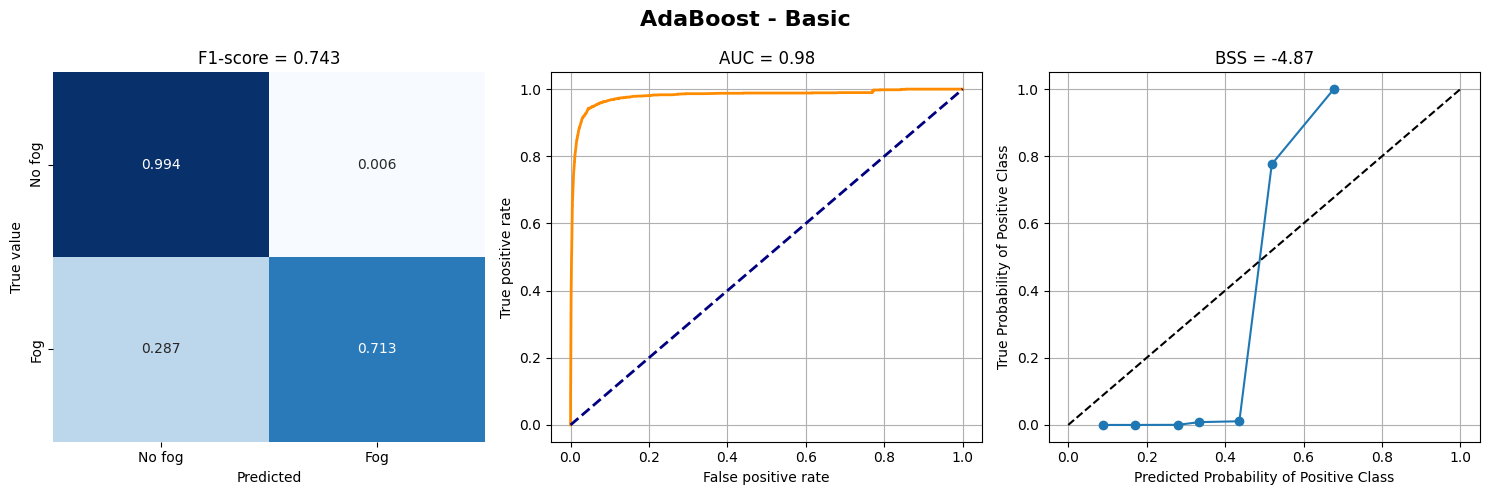

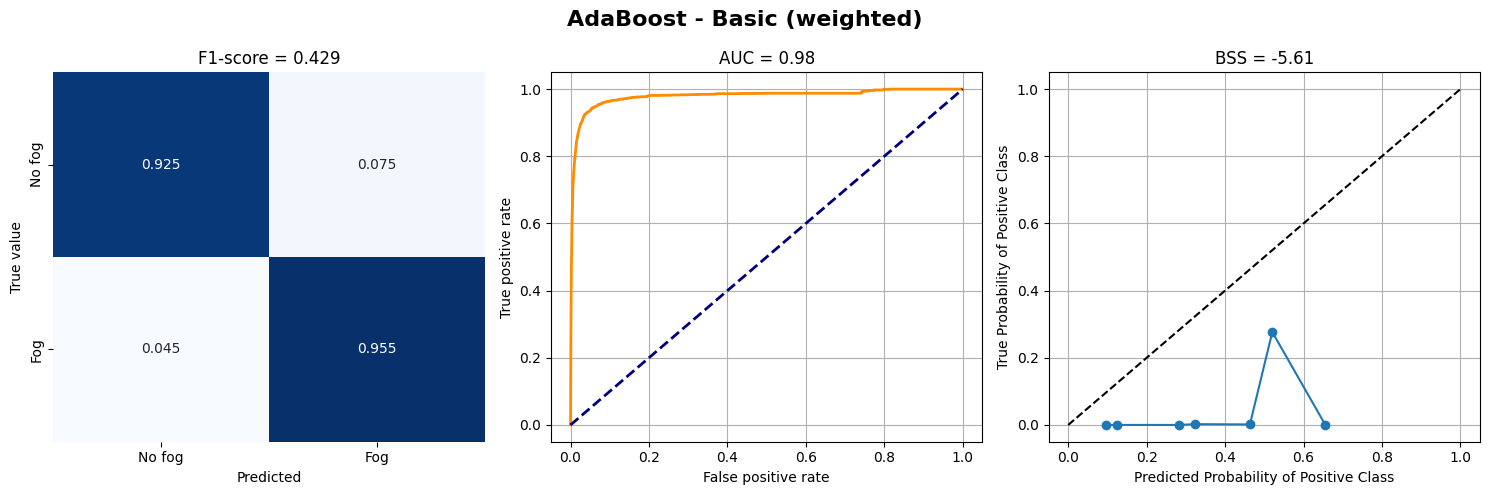

In [ ]:
#@title *Basic model*

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Inital parameter for the basic model
init_n_estimators = 50 #@param {type:"slider", min:10, max:500, step:10}
init_learning_rate = 0.5 #@param {type:"slider", min:0, max:1, step:0.1}

# create an AdaBoost classifier with decision tree stumps as weak learners
base_clf = DecisionTreeClassifier(max_depth=2, class_weight=None, random_state=23)
base_clf_weigthed = DecisionTreeClassifier(max_depth=2, class_weight='balanced', random_state=23)

abc_basic = AdaBoostClassifier(estimator=base_clf,
                               n_estimators=init_n_estimators,
                               learning_rate=init_learning_rate,
                               random_state=23).fit(X_train, y_train)

abc_basic_weighted = AdaBoostClassifier(estimator=base_clf_weigthed,
                                        n_estimators=init_n_estimators,
                                        learning_rate=init_learning_rate,
                                        random_state=23).fit(X_train, y_train)

# Save oane tree from the forest
tree_num = 0
save_decision_tree(tree_model=abc_basic.estimators_[tree_num],
                   filename=f'3_abc_basic_tree{tree_num}')


evaluate(model=abc_basic,
         save=True,
         model_name='3_abc_basic',
         cm_normalize='true',
         plot_title='AdaBoost - Basic')

evaluate(model=abc_basic_weighted,
         save=True,
         model_name='3_abc_basic_weighted',
         cm_normalize='true',
         plot_title='AdaBoost - Basic (weighted)')

### *Hyperparamers tuning*

In [ ]:
abc_params_grid = {
    'n_estimators': [10, 20, 40, 80, 100, 200, 300],
    'learning_rate': [0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
}

n_estimators:   0%|          | 0/7 [00:00<?, ?it/s]

Execution time: 02 minutes 8.56 seconds



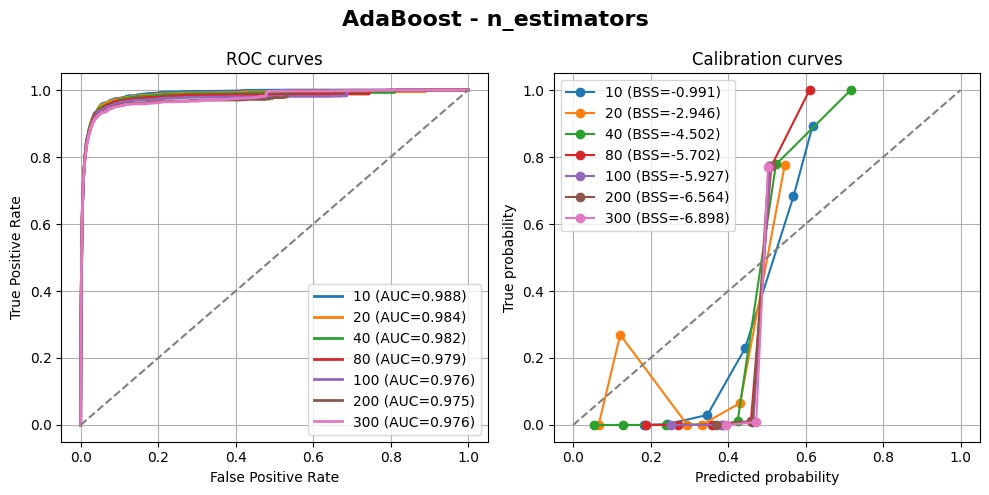

In [ ]:
#@title Number of estimators

abc_n_estimators = []

# Use a loop to iterate over all combinations of the `n_estimators` parameter
start_time = time.time()
for n_estimators in tqdm(abc_params_grid['n_estimators'], desc='n_estimators'):
    ab = AdaBoostClassifier(estimator=base_clf,
                            n_estimators=n_estimators,
                            learning_rate=0.5,
                            random_state=23).fit(X_train, y_train)

    # Generate predictions and compute the probabilities (of
    # the positive class) over the test set
    y_pred = ab.predict(X_test)
    y_prob = ab.predict_proba(X_test)[:, 1]

    # Save predictions
    abc_n_estimators.append((y_pred, y_prob))
end_time = time.time()

# Format and print the elapsed time
elapsed_time = end_time - start_time
minutes, seconds = divmod(elapsed_time, 60)
print(f'Execution time: {int(minutes):02d} minutes {seconds:.2f} seconds\n')

# Plot metrics
eval_grid(params=abc_params_grid['n_estimators'],
          predictions=abc_n_estimators,
          plot_title='AdaBoost - n_estimators',
          model_name='4_abc_n-estimators',
          save=True)

learning_rate:   0%|          | 0/6 [00:00<?, ?it/s]

Execution time: 00 minutes 52.10 seconds



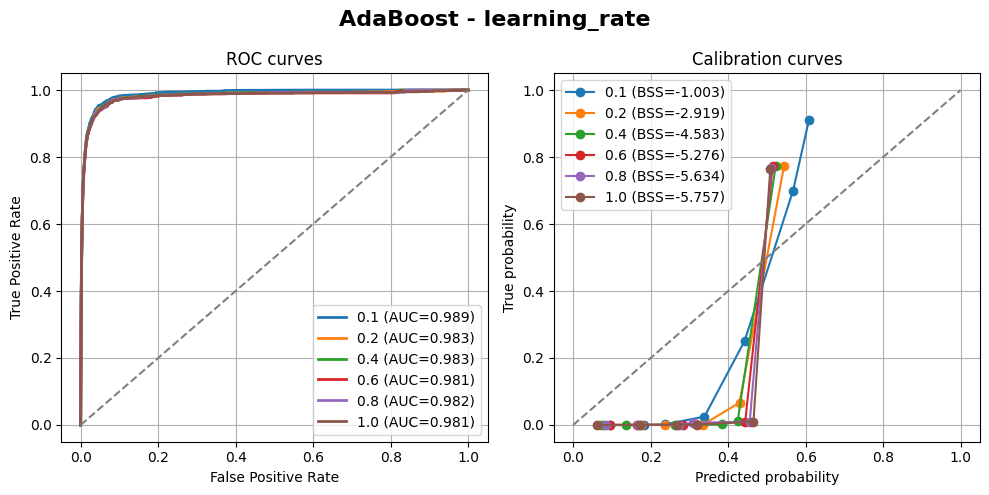

In [ ]:
#@title Learning rate

abc_learning_rate = []

# Use a loop to iterate over all combinations of the `n_estimators` parameter
start_time = time.time()
for learning_rate in tqdm(abc_params_grid['learning_rate'], desc='learning_rate'):
    ab = AdaBoostClassifier(estimator=base_clf,
                            n_estimators=50,
                            learning_rate=learning_rate,
                            random_state=23).fit(X_train, y_train)

    # Generate predictions and compute the probabilities (of
    # the positive class) over the test set
    y_pred = ab.predict(X_test)
    y_prob = ab.predict_proba(X_test)[:, 1]

    # Save predictions
    abc_learning_rate.append((y_pred, y_prob))
end_time = time.time()

# Format and print the elapsed time
elapsed_time = end_time - start_time
minutes, seconds = divmod(elapsed_time, 60)
print(f'Execution time: {int(minutes):02d} minutes {seconds:.2f} seconds\n')

# Plot metrics
eval_grid(params=abc_params_grid['learning_rate'],
          predictions=abc_learning_rate,
          plot_title='AdaBoost - learning_rate',
          model_name='4_abc_learning-rate',
          save=True)

### *Final model*

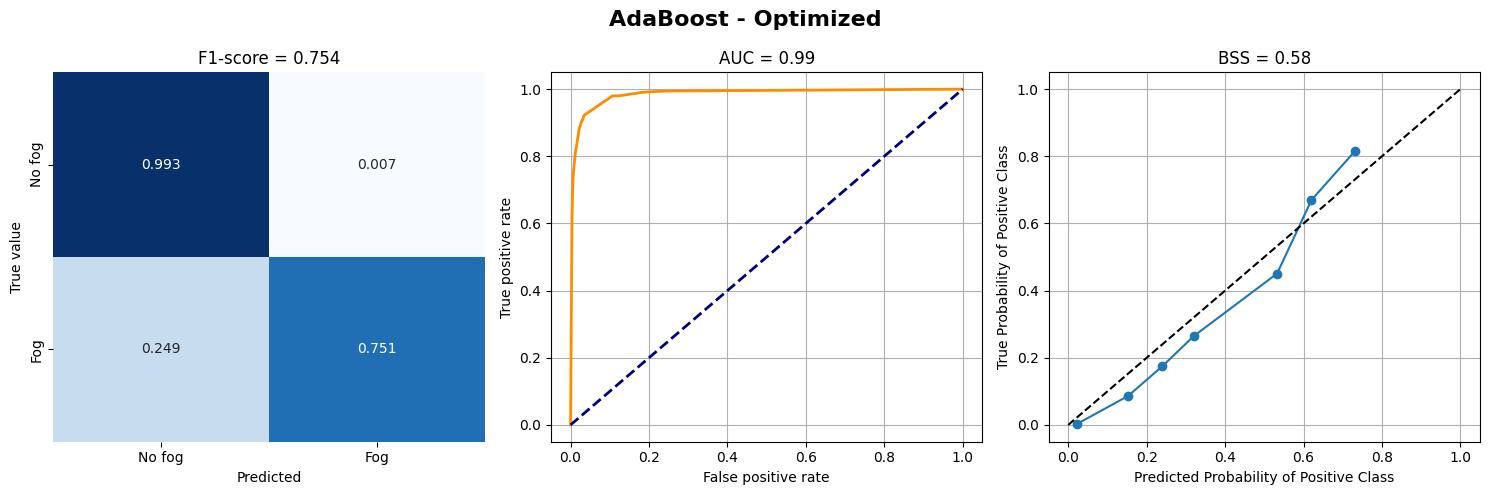

In [ ]:
abc_opti = AdaBoostClassifier(estimator=base_clf,
                               n_estimators=10,
                               learning_rate=0.1,
                               random_state=23).fit(X_train, y_train)


evaluate(model=abc_opti,
         save=True,
         model_name='4_abc_optimized',
         cm_normalize='true',
         plot_title='AdaBoost - Optimized')

In this case the different of the final model from de basic one is more comparable. Part of this differences are related to the methodology used to obtain the "optimized" model, since the evaluation of the hyperparameters is performed independently.

## **4.3. Gradient Boosting**

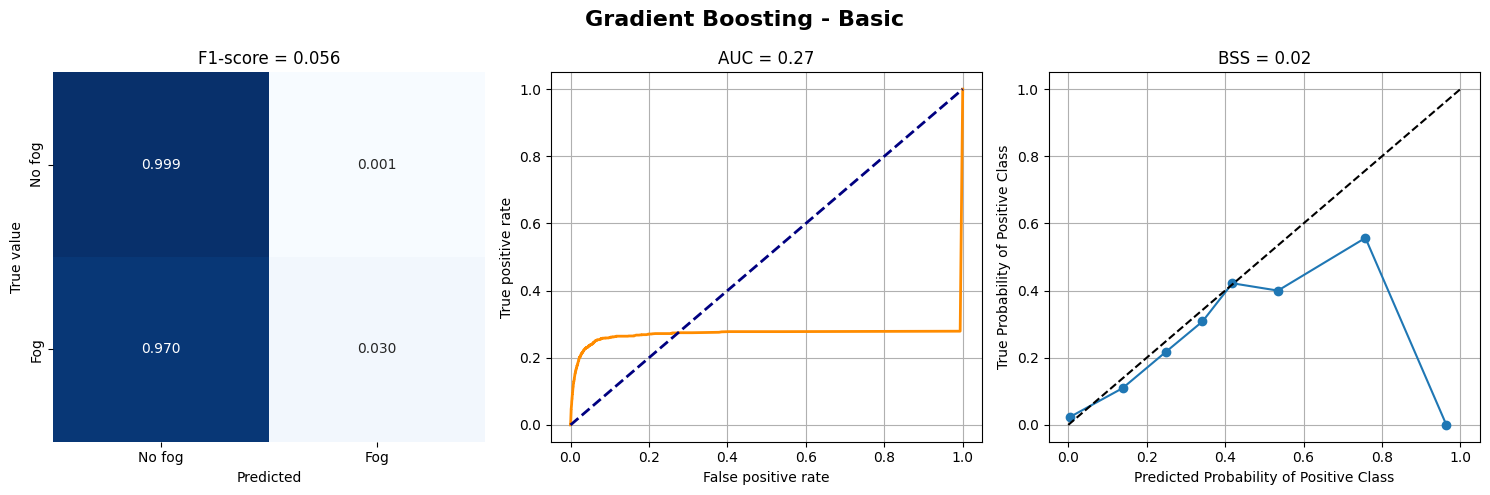

In [ ]:
#@title Basic model

from sklearn.ensemble import GradientBoostingClassifier

# Inital parameter for the basic model
init_n_estimators = 50 #@param {type:"slider", min:10, max:500, step:10}
init_learning_rate = 0.5 #@param {type:"slider", min:0, max:1, step:0.1}

gbc_basic = GradientBoostingClassifier(n_estimators=init_n_estimators, learning_rate=init_learning_rate,
                                       random_state=23).fit(X_train, y_train)

# Save oane tree from the forest
tree_num = 0
save_decision_tree(tree_model=gbc_basic.estimators_[tree_num, 0],
                    filename=f'5_gbc_basic_tree{tree_num}')


evaluate(model=gbc_basic,
         save=True,
         model_name='5_gbc_basic',
         cm_normalize='true',
         plot_title='Gradient Boosting - Basic')

### *Hyperparamers tuning*

In [ ]:
gbc_params_grid = {
    'n_estimators': [10, 20, 40, 80, 100, 200, 300],
    'learning_rate': [0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
}

### *n_estimators*

n_estimators:   0%|          | 0/7 [00:00<?, ?it/s]

Execution time: 02 minutes 13.10 seconds



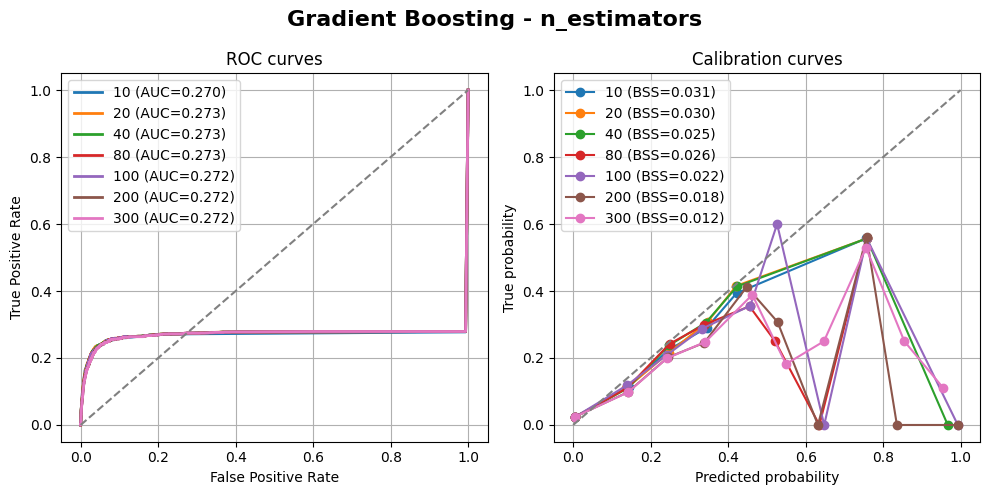

In [ ]:
#@title Number of estimators

gbc_n_estimators = []

# Use a loop to iterate over all combinations of the `n_estimators` parameter
start_time = time.time()
for n_estimators in tqdm(gbc_params_grid['n_estimators'], desc='n_estimators'):
    gb = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=init_learning_rate,
                                    random_state=23).fit(X_train, y_train)

    # Generate predictions and compute the probabilities (of
    # the positive class) over the test set
    y_pred = gb.predict(X_test)
    y_prob = gb.predict_proba(X_test)[:, 1]

    # Save predictions
    gbc_n_estimators.append((y_pred, y_prob))
end_time = time.time()

# Format and print the elapsed time
elapsed_time = end_time - start_time
minutes, seconds = divmod(elapsed_time, 60)
print(f'Execution time: {int(minutes):02d} minutes {seconds:.2f} seconds\n')

# Plot metrics
eval_grid(params=gbc_params_grid['n_estimators'],
          predictions=gbc_n_estimators,
          plot_title='Gradient Boosting - n_estimators',
          model_name='6_gbc_n-estimators',
          save=True)

learning_rate:   0%|          | 0/6 [00:00<?, ?it/s]

Execution time: 00 minutes 53.96 seconds



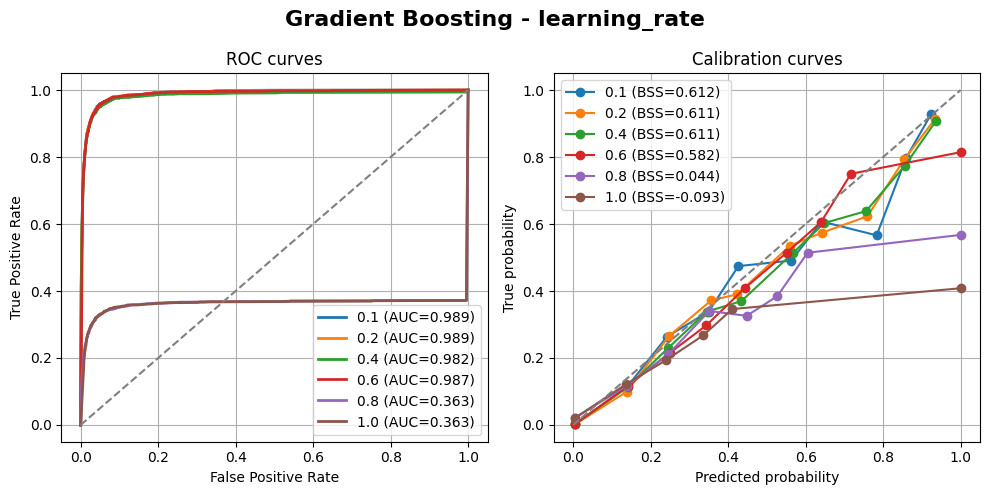

In [ ]:
#@title Learning rate

gbc_learning_rate = []

# Use a loop to iterate over all combinations of the `n_estimators` parameter
start_time = time.time()
for learning_rate in tqdm(gbc_params_grid['learning_rate'], desc='learning_rate'):
    gb = GradientBoostingClassifier(n_estimators=50, learning_rate=learning_rate,
                                    random_state=23).fit(X_train, y_train)

    # Generate predictions and compute the probabilities (of
    # the positive class) over the test set
    y_pred = gb.predict(X_test)
    y_prob = gb.predict_proba(X_test)[:, 1]

    # Save predictions
    gbc_learning_rate.append((y_pred, y_prob))
end_time = time.time()

# Format and print the elapsed time
elapsed_time = end_time - start_time
minutes, seconds = divmod(elapsed_time, 60)
print(f'Execution time: {int(minutes):02d} minutes {seconds:.2f} seconds\n')

# Plot metrics
eval_grid(params=gbc_params_grid['learning_rate'],
          predictions=gbc_learning_rate,
          plot_title='Gradient Boosting - learning_rate',
          model_name='6_gbc_learning-rate',
          save=True)

### *Final model*

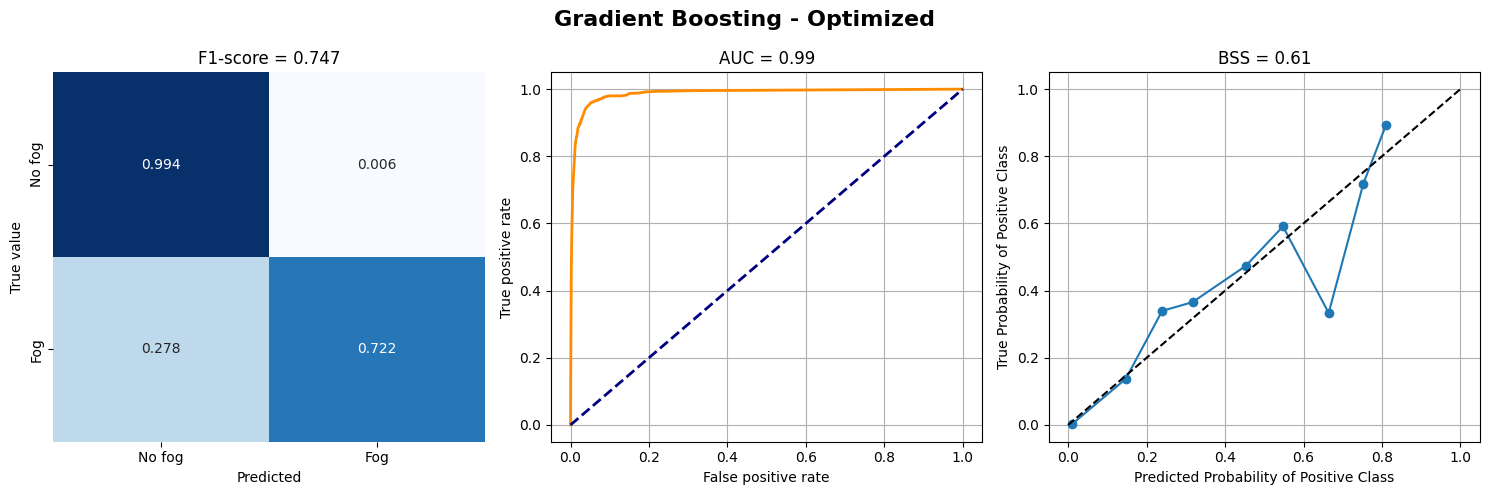

In [ ]:
gbc_opti = GradientBoostingClassifier(n_estimators=20, learning_rate=0.1,
                                      random_state=23).fit(X_train, y_train)

evaluate(model=gbc_opti,
         save=True,
         model_name='6_gbc_optimized',
         cm_normalize='true',
         plot_title='Gradient Boosting - Optimized')

# **Conclusions**

* Tree different ensemble algorithms performance were compared over the meteorological Ezeiza data obtaning a F1-score of 0.75 and a brier skill score of 0.61 as the highest ones.

* Most evaluations performed shows that the score of area under the curve (AUC) presents similar values between 0.98 and 0.99. The only model whose AUC score differs is the Gradient Boosting where AUC scores between 0.27 and 0.36 are obtained.

* Tuning the number of estimators (`n_estimators`) in all the ensembles requires around 2 times the execution time it takes to tune the maximum depth (`max_depth`) and the learning rate (`learning_rate`). However, the evaluation results for the number of estimators do not usually vary as much as the results of the second hyperparameter.

* The confusion matrix, ROC curve and calibration curve are impolemented as visual evaluation metrics. Since the data is unbalances, the confusion matrix is normalized over the true labels for better analysis.

* The final model of each ensamble is obtained by tuning two of the most important hyperparamers of the algorithm. However, this "optimization" is performed independently, that is, while the behavior of one hyperparameter is evaluated, the other remains constant.